In [11]:
# Imports
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

from PIL import Image

In [12]:
def read_images(dir_name):
    base_dir = dir_name

    image_data = {}

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        
        if os.path.isdir(folder_path):
            images = []
            
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                
                if file_path.lower().endswith(('.png', '.jpg')):
                    image = Image.open(file_path)
                    images.append(image)
            
            image_data[folder] = images
    return image_data

In [13]:
def get_colors_around_center_pixel(image, radius=5):
    height, width = image.size
    center_x, center_y = width // 2, height // 2

    colors = []

    for x in range(center_x - radius, center_x + radius + 1):
        for y in range(center_y - radius, center_y + radius + 1):
            if 0 <= x < width and 0 <= y < height:
                pixel_color = image.getpixel((x, y))
                colors.append(pixel_color)

    return colors


In [14]:
def hsv_color_similarity(color1, color2):
    hue_diff = abs(color1[0] - color2[0])
    sat_diff = abs(color1[1] - color2[1])
    val_diff = abs(color1[2] - color2[2])
    return hue_diff + sat_diff + val_diff

In [15]:
def region_growing(image, seed, colors, threshold, visited):
    width, height = image.size
    stack = [seed]
    region = []
    target_colors = set(colors)  # Usamos um conjunto para verificação mais eficiente

    while stack:
        x, y = stack.pop()
        if not visited[x, y]:
            visited[x, y] = True
            pixel_color = image.getpixel((x, y))
            if any(hsv_color_similarity(pixel_color, target_color) <= threshold for target_color in target_colors):
                region.append((x, y))

                neighbors_8 = [
                    (x - 1, y - 1), (x, y - 1), (x + 1, y - 1),
                    (x - 1, y), (x + 1, y),
                    (x - 1, y + 1), (x, y + 1), (x + 1, y + 1)
                ]

                neighbors_4 = [
                    (x, y - 1),
                    (x - 1, y),
                    (x + 1, y),
                    (x, y + 1)
                ]
                
                stack.extend((n for n in neighbors_4 if 0 <= n[0] < width and 0 <= n[1] < height))

    return region

In [16]:
def contour_segmented_images(segmented_image):
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(binary)
    contours_per_image, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours_per_image, key=cv2.contourArea)
    return largest_contour

In [17]:
def apply_mask(image_data, contours):
    mask = np.zeros_like(image_data, dtype=np.uint8)
    cv2.drawContours(mask, [contours], 0, (255, 255, 255), thickness=cv2.FILLED)
    segmented_image_with_contour = cv2.bitwise_and(np.array(image_data), mask)
    return segmented_image_with_contour


In [18]:
def process_segmentation(image_data):
    segmented_images = {}

    for folder, images in image_data.items():
        segmented_image_list = []

        for image in images:
            center_colors = get_colors_around_center_pixel(image, radius=4)
            seed = (image.width // 2, image.height // 2)
            threshold = 30  # Ajuste este valor de acordo com a similaridade desejada
            visited = np.zeros((image.width, image.height), dtype=bool)
            region = region_growing(image, seed, center_colors, threshold, visited)

            # Crie uma nova imagem com o fundo branco e depois adicione a região segmentada
            segmented_image = Image.new('RGB', image.size, (255, 255, 255))
            for pixel in region:
                segmented_image.putpixel(pixel, image.getpixel(pixel))
            segmented_image_list.append(segmented_image)
            # plot_single_image_and_original(segmented_image, image) # Plotar as imagens conforme for segmentando para ver se está sendo certo
        segmented_images[folder] = segmented_image_list
    return segmented_images


In [19]:
def process_contours(segmented_images, image_data):
    final_segmentation = {}
    contours_final_segmentation = {}

    for folder, images in segmented_images.items():
        final_segmentation_list = []
        contours_final_segmentation_list = []

        num_images = len(images)
        for i in range(0, num_images):
            array_image = np.array(segmented_images.get(folder)[i])
            contours = contour_segmented_images(array_image)
            final_segmentation_image = apply_mask(image_data.get(folder)[i], contours)
            # casting_image = Image.fromarray(final_segmentation_image) # Caso precise
            final_segmentation_list.append(final_segmentation_image)
            contours_final_segmentation_list.append(contours)

        final_segmentation[folder] = final_segmentation_list
        contours_final_segmentation[folder] = contours_final_segmentation_list
    return final_segmentation, contours_final_segmentation,

In [20]:
image_data = read_images('../src/images-processed/')

In [21]:
segmented_images = process_segmentation(image_data)
# segmented_images = read_images('../segmented-images/')

In [22]:
final_segmentation, contours_final_segmentation = process_contours(segmented_images, image_data)

In [ ]:
import pandas as pd
import math

def calculate_area(image, black_color=[0, 0, 0]):
    non_black_pixels = np.argwhere(np.all(np.array(image) != black_color, axis=-1))
    return len(non_black_pixels)

def calculate_compactness(area, contour):
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / (4 * np.pi * area)
    return compactness

def calculate_eccentricity(image, black_color=[0, 0, 0]):
    non_black_pixels = np.argwhere(np.all(np.array(image) != black_color, axis=-1))
    moments = cv2.moments(non_black_pixels)
    Ixx = moments['mu20']
    Iyy = moments['mu02']
    Ixy = moments['mu11']
    a = (Ixx + Iyy) / 2 + np.sqrt(4 * Ixy**2 + (Ixx - Iyy)**2) / 2
    b = (Ixx + Iyy) / 2 - np.sqrt(4 * Ixy**2 + (Ixx - Iyy)**2) / 2
    eccentricity = np.sqrt(1 - b/a)
    return eccentricity

def extract_features(image_data, contours_final_segmentation):
    data = {'Class': [], 'Area': [], 'Compactness': [], 'Eccentricity': []}

    for class_label, images in image_data.items():
        for i, image in enumerate(images):
            contour = contours_final_segmentation[class_label][i]
            area = calculate_area(image)
            compactness = calculate_compactness(area, contour)
            eccentricity = calculate_eccentricity(image)

            if math.isnan(eccentricity):
                eccentricity = 0

            data['Class'].append(class_label)
            data['Area'].append(area)
            data['Compactness'].append(compactness)
            data['Eccentricity'].append(eccentricity)

    return pd.DataFrame(data)

# Calculate features
features_df = extract_features(final_segmentation, contours_final_segmentation)

# Save to CSV
features_df.to_csv('features.csv', index=False)

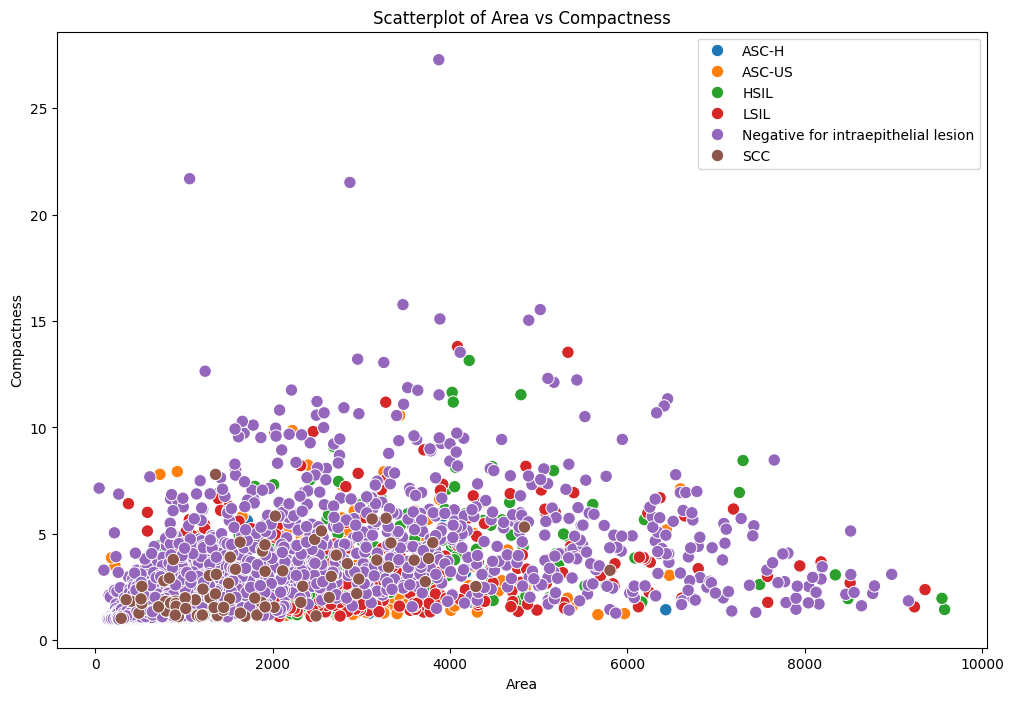

In [31]:
import seaborn as sns

# Get unique classes from the 'Class' column in your DataFrame
unique_classes = features_df['Class'].unique()

# Create a color palette with distinct colors for each class
class_palette = {class_label: sns.color_palette()[i] for i, class_label in enumerate(unique_classes)}

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Area', y='Compactness', hue='Class', data=features_df, palette=class_palette, s=80)

plt.title('Scatterplot of Area vs Compactness')
plt.xlabel('Area')
plt.ylabel('Compactness')
plt.legend()
plt.show()

In [25]:
def display_all_images(data, num_images_to_display=10):
    for folder, images in data.items():
        print(f"Folder: {folder}")
        num_images = len(images)
        
        for i in range(0, num_images, num_images_to_display):
            fig, axes = plt.subplots(1, min(num_images_to_display, num_images - i), figsize=(15, 5))
            
            if num_images_to_display == 1:
                axes = [axes]
                
            for j, ax in enumerate(axes):
                if j + i < num_images:
                    ax.imshow(images[i + j], cmap='gray')
                    ax.axis('off')
            
            plt.show()

In [26]:
def plot_single_image_and_original(segmented_image, original_image):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')
    plt.axis('off')

    plt.show()

In [27]:
def create_folders_classes(classes):
        try:
            for class_name in classes:
                class_dir = os.path.join('../segmented-images/', class_name)
                os.makedirs(class_dir, exist_ok=True)
            print('Diretórios criados com sucesso.')
            return True
        except Exception as e:
            raise Exception(f'Erro ao criar diretórios: {str(e)}')

In [28]:
def write_segmented_images(image_data, segmented_images, output_dir):
    for folder, images in image_data.items():
        segmented_folder = os.path.join(output_dir, folder)
        os.makedirs(segmented_folder, exist_ok=True)

        for image, segmented_image in zip(images, segmented_images[folder]):
            image_name = os.path.splitext(os.path.basename(image.filename))[0]
            output_filename = f"{image_name}_segmented.jpg"
            output_path = os.path.join(segmented_folder, output_filename)
            segmented_image = Image.fromarray(segmented_image)
            segmented_image.save(output_path)
    print(f'Todas as imagens carregadas para {output_dir}')


In [ ]:
CLASSES = ['Negative for intraepithelial lesion', 'ASC-US', 'ASC-H', 'LSIL', 'HSIL', 'SCC']
create_folders_classes(CLASSES)
write_segmented_images(image_data, final_segmentation, '../src/segmented-images/')

In [ ]:
import os
import shutil
import random

def separate_dataset(dataset_path, output_path, percentage_train=0.8):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for _class in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, _class)
        if os.path.isdir(class_path):
            files_class = os.listdir(class_path)

            random.shuffle(files_class)

            index_train = int(len(files_class) * percentage_train)

            train_data = files_class[:index_train]
            test_data = files_class[index_train:]

            train_path = os.path.join(output_path, 'train', _class)
            test_path = os.path.join(output_path, 'test', _class)

            os.makedirs(train_path, exist_ok=True)
            os.makedirs(test_path, exist_ok=True)

            for _file in train_data:
                shutil.copy2(os.path.join(class_path, _file), train_path)

            for _file in test_data:
                shutil.copy2(os.path.join(class_path, _file), test_path)

In [ ]:
dataset_path = '../src/segmented-images'
output_path = '../src/separate_dataset'

separate_dataset(dataset_path, output_path)